In [20]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model

import seaborn as sns
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import time

import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

WINDOW = 22

In [24]:
def connect(user, password, db, host: str, port: int, echo=True):
    url = 'postgresql+psycopg2://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, db)
    eng = sqlalchemy.create_engine(url, client_encoding='utf8', echo=echo)
    meta = sqlalchemy.MetaData(bind=eng)

    return eng, meta


def get_data_frame(pair: str = 'USDT_BTC') -> pd.DataFrame:
    """Метод стягивания данных из базы в датафрейм.
    По умолчанию тянет все значения в базе для валютной пары доллар биткоин.
    Список спаршенных пар смотри в таблице Pair
    Цепляться будет отовсюду где есть инетрнет"""
    engine, meta = connect(user='postgres', password='password', db='btccandles', host='176.212.125.30', port=16432)
    df = pd.read_sql_query(
        'select date, time, open, close, low, high, volume, pair."name" from candlestick, pair '
        'where candlestick.pair_id=pair.id and pair."name"=\'' + pair + '\';',
        con=engine)
    return df

df = get_data_frame()

In [42]:
df.tail()

,date,time,open,close,low,high,volume,name
714,2017-07-15,07:00:00,2205.907300,1977.500000,1972.000010,2213.872903,5.927525e+07,USDT_BTC
715,2017-07-16,07:00:00,1977.500000,1925.900000,1835.000277,2054.000000,6.640352e+07,USDT_BTC
716,2017-07-17,07:00:00,1922.193300,2223.403082,1922.193300,2224.845000,5.942922e+07,USDT_BTC
717,2017-07-18,07:00:00,2223.403082,2300.000000,2117.270963,2390.000000,7.418737e+07,USDT_BTC
718,2017-07-19,07:00:00,2300.000000,2365.100000,2237.000000,2409.904970,2.232252e+07,USDT_BTC


In [36]:
scaler = MinMaxScaler()

all_df = df.copy()

x = all_df['close'].copy()
y = all_df['close'].copy()

x = scaler.fit_transform(x.values.reshape(-1, 1))

y = scaler.fit_transform(y.values.reshape(-1, 1))

In [37]:
def load_data(X, seq_len, train_size=1):
    # Определяем число фич
    amount_of_features = X.shape[1] 
    
    sequence_length = seq_len + 1 
    data = []
    
    # Бьем тренировочные данные на блоки по размеру окна
    for index in range(len(X) - sequence_length):
        data.append(X[index: index + sequence_length])
    
    data = np.array(data)
    train_split = int(round(train_size * data.shape[0]))
    train_data = data[:train_split, :]
    
    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]
    
    # Меняем размер входного фрейма на [dim, window, featureNumber]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    return x_train, y_train

X_train, y_train = load_data(x, WINDOW)

print (X_train.shape, y_train.shape)

(696, 22, 1) (696,)


In [10]:
def build_model(input_shape):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="normal",activation='relu'))        
    model.add(Dense(1,kernel_initializer="normal",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    
    return model

In [11]:
model = build_model(input_shape=(WINDOW, 1))

In [12]:
print('START FIT MODEL...')
start = time.time()
model.fit(X_train, y_train, batch_size=32, epochs=500,
          verbose=0)
end = time.time()

print ('Learning time: ', end-start)

START FIT MODEL...


InternalError: Blas GEMM launch failed : a.shape=(704, 1), b.shape=(1, 128), m=704, n=128, k=1
	 [[Node: lstm_1/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](lstm_1/Reshape, lstm_1/strided_slice)]]
	 [[Node: mul_1/_53 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_4517_mul_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'lstm_1/MatMul', defined at:
  File "/root/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/root/anaconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/root/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/root/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/root/anaconda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/root/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/root/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/root/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/root/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/root/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/root/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/root/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/root/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/root/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/root/anaconda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/root/anaconda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/root/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/root/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/root/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-fd12d0e327be>", line 1, in <module>
    model = build_model(input_shape=(WINDOW, 1))
  File "<ipython-input-10-bfe51caef30d>", line 5, in build_model
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
  File "/root/anaconda/lib/python3.6/site-packages/keras/models.py", line 422, in add
    layer(x)
  File "/root/anaconda/lib/python3.6/site-packages/keras/layers/recurrent.py", line 252, in __call__
    return super(Recurrent, self).__call__(inputs, **kwargs)
  File "/root/anaconda/lib/python3.6/site-packages/keras/engine/topology.py", line 554, in __call__
    output = self.call(inputs, **kwargs)
  File "/root/anaconda/lib/python3.6/site-packages/keras/layers/recurrent.py", line 290, in call
    preprocessed_input = self.preprocess_input(inputs, training=None)
  File "/root/anaconda/lib/python3.6/site-packages/keras/layers/recurrent.py", line 1023, in preprocess_input
    timesteps, training=training)
  File "/root/anaconda/lib/python3.6/site-packages/keras/layers/recurrent.py", line 50, in _time_distributed_dense
    x = K.dot(x, w)
  File "/root/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 846, in dot
    out = tf.matmul(x, y)
  File "/root/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1816, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/root/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1217, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "/root/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/root/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/root/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(704, 1), b.shape=(1, 128), m=704, n=128, k=1
	 [[Node: lstm_1/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](lstm_1/Reshape, lstm_1/strided_slice)]]
	 [[Node: mul_1/_53 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_4517_mul_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
save_model(model, "../modelOneFeature/model_btc_close_oneFeature5days19_07_db.h5")

In [10]:
model = load_model("../modelOneFeature/model_btc_close_oneFeature5days19_07_db.h5")

In [21]:
# Test model - how works train_on_batch
# Тестирование дообучения
"""import time

start = time.time()
print('START FIT MODEL...')
model_min_o = build_model(input_shape=(WINDOW, 1))
model_min_o.fit(X_train[:-1], y_train[:-1], batch_size=32, epochs=500,
          verbose=0)
end = time.time()

print ('Learning time: ', end-start)
model_min_o.train_on_batch(X_train[693].reshape(1,22, 1), y_train[693].reshape(1,))
print (scaler.inverse_transform(model_min_o.predict([x[-WINDOW:].reshape(1,22, 1)])))

print (scaler.inverse_transform(model.predict([x[-WINDOW:].reshape(1,22, 1)])))"""

START FIT MODEL...
Learning time:  402.83589601516724
[[ 2084.13012695]]
[[ 2202.64501953]]


In [11]:
trainPredict = model.predict(X_train)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])

trainScore = metrics.mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 42.59 RMSE


In [12]:
prices = all_df.close.values.astype('float32')
prices = prices.reshape(len(prices), 1)

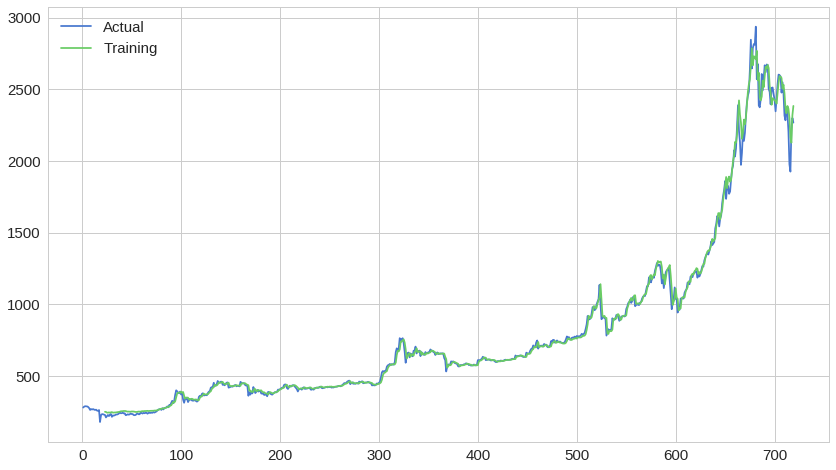

In [13]:
trainPredictPlot = np.empty_like(prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[WINDOW:len(trainPredict)+WINDOW, :] = trainPredict

plt.plot(pd.DataFrame(prices, columns=["close"], index=all_df.index).close, label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=all_df.index).close, label='Training')
plt.legend(loc='best')
plt.show()


In [94]:
df.tail()

,date,time,open,close,low,high,volume,pair_id
#,,,,,,,,
714,2017-07-14,07:00:00.000000,2327.300000,2205.907300,2134.000000,2350.000000,3.329353e+07,83
715,2017-07-15,07:00:00.000000,2205.907300,1977.500000,1972.000010,2213.872903,5.927525e+07,83
716,2017-07-16,07:00:00.000000,1977.500000,1925.900000,1835.000277,2054.000000,6.640352e+07,83
717,2017-07-17,07:00:00.000000,1922.193300,2223.403082,1922.193300,2224.845000,5.942922e+07,83
718,2017-07-18,07:00:00.000000,2223.403082,2266.100001,2117.270963,2287.608020,2.011914e+07,83


In [1]:
import datetime 

def predictNumDay(num):
    m = load_model("../modelOneFeature/model_btc_close_oneFeature5days19_07_db.h5")
    
    prediction = []
    lastbatch = (x[-WINDOW:])
    for i in np.arange(num):    
        res = m.predict([lastbatch.reshape(1,22, 1)])
        prediction.append(scaler.inverse_transform(res))
        lastbatch = np.concatenate([lastbatch[1:],res])
        m.train_on_batch(lastbatch.reshape(1,22,1), res)
    
       
    return np.array(prediction).reshape(num)   

N = 5

lastDate =str(df.date[df.last_valid_index()]).split('-')
currentData = datetime.date(int(lastDate[0]),int(lastDate[1]),int(lastDate[2])+1)
predictionDate = pd.date_range(currentData,periods=N)
print (predictionDate)

predict5day =  (predictNumDay(N))
print (predict5day)

prediction = pd.DataFrame(predict5day, columns=["predictionPrice"], index = predictionDate.values)

NameError: name 'df' is not defined

In [2]:
Actual = pd.DataFrame(prices, columns=["close"], index=all_df.date).close
Training = pd.DataFrame(trainPredictPlot, columns=["close"], index=all_df.date).close
pred = pd.DataFrame(trainPredictPlot, columns=["close"], index=all_df.date).close

ActualValues = go.Scatter( x = df.date, y = Actual, name = 'ActualValues')
TrainingValues = go.Scatter( x = df.date, y = Training, name = 'TrainingValues')

iplot([ActualValues,TrainingValues])

NameError: name 'pd' is not defined

In [3]:
our_Predict = go.Scatter( x = prediction.index, y = prediction.predictionPrice, name = 'Next5DayValues')

iplot([our_Predict, ActualValues])

NameError: name 'go' is not defined